<a href="https://colab.research.google.com/github/ZPavlo/ML_projects/blob/master/person_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DATA = 'gdrive/My Drive/data_lfw/'

Mounted at /content/gdrive


# Data processing

[Data source](http://vis-www.cs.umass.edu/lfw/)

In [2]:
from sklearn.datasets import fetch_lfw_pairs

In [3]:
train_data  = fetch_lfw_pairs("train", ROOT_DATA, resize=1.0, color=True)
test_data  = fetch_lfw_pairs("test", ROOT_DATA, resize=1.0, color=True)

In [4]:
X_train = train_data["pairs"]
X_test = test_data["pairs"]

y_train = train_data["target"]
y_test = test_data["target"]

In [6]:
import cv2
import numpy as np

def random_rotation(image, max_angle=0.25):

    angle, = (np.random.rand(1) * 2 - 1.0) * max_angle
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, np.degrees(angle), 1.0)
    image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return image

def perspective_transform(image, max_shift=(7, 5), range_of_scale=(0.9, 1.2)):
    h, w, _ = (125, 94, 3)
    pts1 = np.array([[0.0, 0.0], [h, 0.0], [h, w], [0.0, w]])
    pts2 = np.array([[0.0, 0.0], [h, 0.0], [h, w], [0.0, w]])

    # perspective transform
    scale_min, scale_max = np.log2(range_of_scale)
    scale = np.exp2(np.random.rand(4, 1) * (scale_max - scale_min) + scale_min)
    pts2 = (pts2 - np.array([[h, w]]) / 2.0) * scale + np.array([[h, w]]) / 2.0

    # shift
    shift = (np.random.rand(2) * 2 - 1.0) * np.array(max_shift)
    pts2 += shift

    M = cv2.getPerspectiveTransform(pts1.astype(np.float32), pts2.astype(np.float32))
    warped = cv2.warpPerspective(image, M, (w, h))
    return warped

def random_flip(image):
    if np.random.rand() > 0.5:
      return np.flip(image, axis=1)
    else:
      return np.flip(image, axis=1)

def random_gamma_corrected(image, gamma_range=(0.5, 2.0), difficult=1.0):
    gamma_min, gamma_max = np.log2(gamma_range)

    gamma = np.exp2(np.random.rand() * (gamma_max - gamma_min) + gamma_min)

    return 255.0 * (image / 255.0) ** gamma

def pair_data_augmentation(X_data, y_data, data_scale=5.0):
    batch_size, _, h, w, _ = X_data.shape

    indexes = np.arange(batch_size * data_scale).astype(np.int) % batch_size
    np.random.shuffle(indexes)

    y_res = y_data[indexes]

    X_res = []
    for idx in indexes:
        res_dir = []
        for image in X_data[idx]:
            image = random_flip(image)
            image = random_gamma_corrected(image)
            image = perspective_transform(image)
            image = random_rotation(image)
            res_dir.append(image)
        X_res.append(res_dir)
    X_res = np.array(X_res).astype(np.float32)
    return X_res, y_res


X_augm, y_augm = pair_data_augmentation(X_train, y_train, data_scale=3.0)

In [7]:
import cv2
import numpy as np

IMAGE_SHAPE = (32, 32)

def crop_resize_images(X_data, resize=(32, 32)):
    _, _, h, w, c = X_data.shape
    top = (h - w) // 2
    down = top + w

    X_data = X_data.astype(np.uint8)
    X_data = X_data[:, :, top:down]
    X_res = []
    for pair in X_data:
        res_dir = []
        for face in pair:
            res_dir.append(cv2.resize(face, dsize=resize))
        X_res.append(res_dir)
    
    X_res = np.array(X_res).astype(np.float32)
    X_res = np.transpose(X_res, (0, 2, 3, 1, 4))
    X_res = np.reshape(X_res, (-1, resize[0], resize[1], 2 * c))

    return  2.0 * X_res / 256.0 - 1.0

X_train = crop_resize_images(X_train, resize=IMAGE_SHAPE)
X_test = crop_resize_images(X_test, resize=IMAGE_SHAPE)

In [8]:
X_augm = crop_resize_images(X_augm, resize=IMAGE_SHAPE)

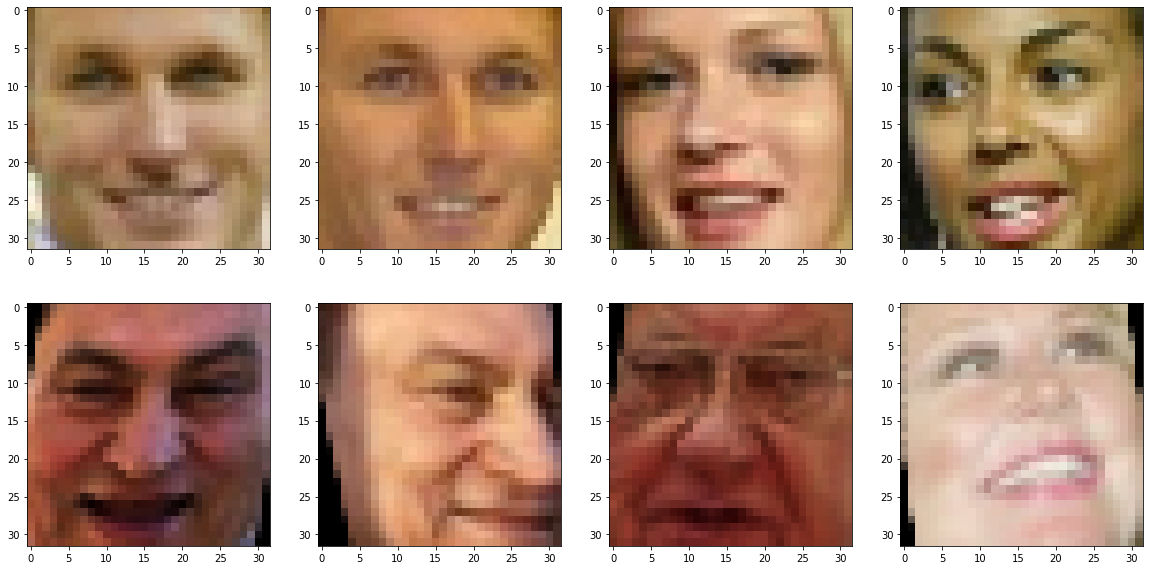

In [15]:
import numpy as np
from matplotlib import pyplot as plt 

fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(2, 4, 1)
ax_2 = fig.add_subplot(2, 4, 2)
ax_3 = fig.add_subplot(2, 4, 3)
ax_4 = fig.add_subplot(2, 4, 4)

same = np.argmax(y_train)
diff = np.argmin(y_train)

ax_1.imshow(((X_train[same, ..., :3] + 1.0) * 128).astype(np.uint8))
ax_2.imshow(((X_train[same, ..., 3:] + 1.0) * 128).astype(np.uint8))

ax_3.imshow(((X_train[diff, ..., :3] + 1.0) * 128).astype(np.uint8))
ax_4.imshow(((X_train[diff, ..., 3:] + 1.0) * 128).astype(np.uint8))


ax_1 = fig.add_subplot(2, 4, 5)
ax_2 = fig.add_subplot(2, 4, 6)
ax_3 = fig.add_subplot(2, 4, 7)
ax_4 = fig.add_subplot(2, 4, 8)

same = np.argmax(y_augm)
diff = np.argmin(y_augm)

ax_1.imshow(((X_augm[same, ..., :3] + 1.0) * 128).astype(np.uint8))
ax_2.imshow(((X_augm[same, ..., 3:] + 1.0) * 128).astype(np.uint8))

ax_3.imshow(((X_augm[diff, ..., :3] + 1.0) * 128).astype(np.uint8))
ax_4.imshow(((X_augm[diff, ..., 3:] + 1.0) * 128).astype(np.uint8))

In [17]:
print("Same faces: {}".format(np.sum(y_train == 1.0)))
print("Different faces: {}".format(np.sum(y_train == 0.0)))

print("Same augmented faces: {}".format(np.sum(y_augm == 1.0)))
print("Different augmented faces: {}".format(np.sum(y_augm == 0.0)))

Same faces: 1100
Different faces: 1100
Same augmented faces: 3300
Different augmented faces: 3300


# Training

## Encoder dist model

In [18]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, AveragePooling2D
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras import utils

def create_encoder_norm_model(input_shape, kernel=3): 
    image_pair = keras.Input(shape=input_shape, name="pair_face")

    face1, face2 = tf.split(image_pair, [3, 3], axis=3)

    encoder = Sequential()


    encoder.add(Conv2D(32, (kernel,kernel),
                    padding='valid',
                    data_format='channels_last',
                    activation='relu'))

    encoder.add(Conv2D(64, (kernel,kernel),
                    padding='valid', 
                    data_format='channels_last',
                    activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2),
                              data_format='channels_last'))
    encoder.add(Dropout(0.5))
    encoder.add(Conv2D(128, (kernel,kernel),
                    padding='valid', 
                    data_format='channels_last',
                    activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2),
                              data_format='channels_last'))
    encoder.add(Flatten())
    # encoder.add(Dense(128))


    code1 = encoder(face1)
    code2 = encoder(face2)

    res = keras.activations.sigmoid(tf.norm(code1-code2, axis=1, ord='euclidean'))

    model = keras.Model(inputs=image_pair, outputs=res)
    
    return model


In [ ]:
encoder_norm_model = create_encoder_norm_model((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 6), kernel=3)
encoder_norm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
encoder_norm_model.summary()

In [ ]:
mcp_save = keras.callbacks.ModelCheckpoint('encoder_norm.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='max')

history = encoder_norm_model.fit(X_train, y_train, 
           batch_size=32, 
           epochs=30, 
           verbose=2,
           callbacks=[mcp_save],
           validation_data=(X_test, y_test))

## Encoder model

In [24]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, AveragePooling2D
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras import utils

def create_encoder_model(input_shape, kernel=3): 
    image_pair = keras.Input(shape=input_shape, name="pair_face")

    face1, face2 = tf.split(image_pair, [3, 3], axis=3)

    encoder = Sequential()


    encoder.add(Conv2D(32, (kernel,kernel),
                    padding='valid',
                    data_format='channels_last',
                    activation='relu'))

    encoder.add(Conv2D(64, (kernel,kernel),
                    padding='valid', 
                    data_format='channels_last',
                    activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2),
                              data_format='channels_last'))
    encoder.add(Dropout(0.5))
    encoder.add(Conv2D(128, (kernel,kernel),
                    padding='valid', 
                    data_format='channels_last',
                    activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2),
                              data_format='channels_last'))
    encoder.add(Flatten())
    # encoder.add(Dense(128))


    code1 = encoder(face1)
    code2 = encoder(face2)

    compare = Sequential()
    compare.add(Dense(32, activation='relu'))
    compare.add(Dropout(0.5))
    compare.add(Dense(1, activation='sigmoid'))

    res = compare(tf.concat([code1, code2], axis=1))

    model = keras.Model(inputs=image_pair, outputs=res)
    
    return model


In [ ]:
encoder_model = create_encoder_model((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 6), kernel=3)
encoder_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
encoder_model.summary()

In [ ]:
mcp_save = keras.callbacks.ModelCheckpoint('encoder.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='max')

history = encoder_model.fit(X_train, y_train, 
           batch_size=32, 
           epochs=100, 
           verbose=1,
           callbacks=[mcp_save],
           validation_data=(X_test, y_test))

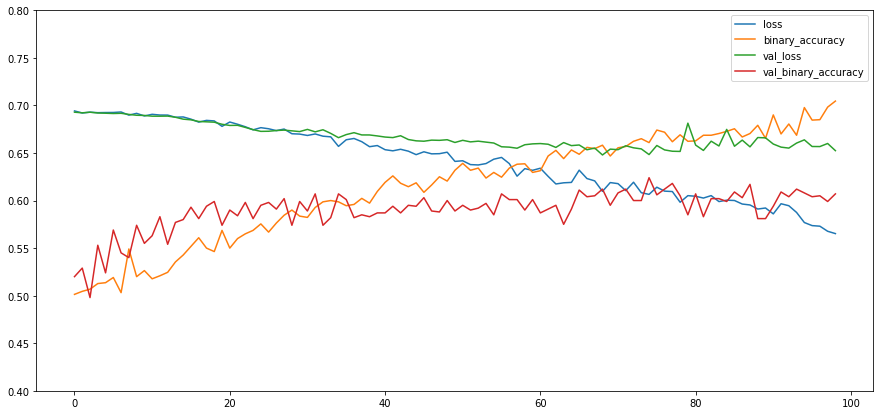

In [33]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 7))

plt.plot(history.history["loss"][1:], label = 'loss')
plt.plot(history.history["binary_accuracy"][1:], label = 'binary_accuracy')
plt.plot(history.history["val_loss"][1:], label = 'val_loss')
plt.plot(history.history["val_binary_accuracy"][1:], label = 'val_binary_accuracy')

plt.ylim(0.4, 0.8)

plt.legend()

In [34]:
encoder_model = create_encoder_model((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 6), kernel=3)
encoder_model.load_weights("encoder.hdf5")
encoder_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])

encoder_model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 0s 4ms/step - loss: 0.6483 - binary_accuracy: 0.6240


[0.6483248472213745, 0.6240000128746033]

## Pretrain model

In [35]:
from tensorflow.keras.applications import ResNet50

def create_encoder_resnet_model(input_shape=(32, 32, 6)): 

    faces = keras.Input(shape=input_shape, name="pair_face")

    face1, face2 = tf.split(faces, [3, 3], axis=3)

    encoder = ResNet50(input_tensor=face1, include_top=False, weights="imagenet")

    encoder_top = Sequential()
    encoder_top.add(Flatten())
    encoder_top.add(Dense(128))

    code1 = encoder_top(encoder(face1))
    code2 = encoder_top(encoder(face2))

    compare = Sequential()
    compare.add(Dense(32, activation='relu'))
    compare.add(Dropout(0.5))
    compare.add(Dense(1, activation='sigmoid'))

    res = compare(tf.concat([code1, code2], axis=1))

    model = keras.Model(inputs=faces, outputs=res)

    return model

In [ ]:
resnet_encoder_model = create_encoder_resnet_model((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 6))
resnet_encoder_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
resnet_encoder_model.summary()

In [ ]:
mcp_save = keras.callbacks.ModelCheckpoint('resnet_encoder.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='max')

history = resnet_encoder_model.fit(X_train, y_train, 
           batch_size=32, 
           epochs=25, 
           verbose=1,
           callbacks=[mcp_save],
           validation_data=(X_test, y_test))

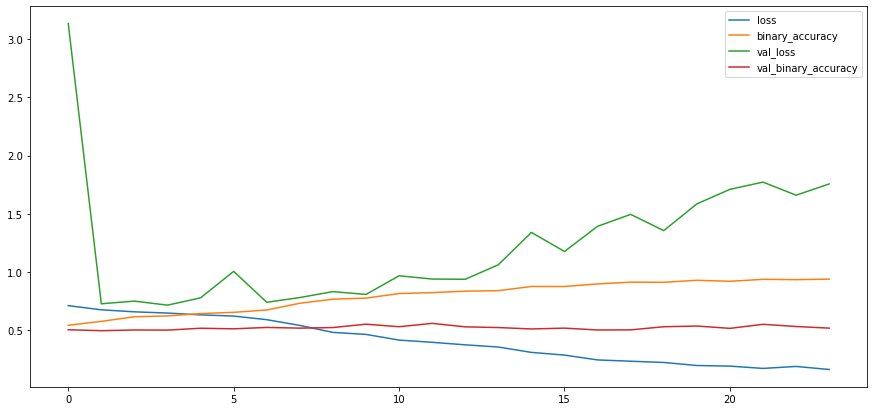

In [38]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 7))

plt.plot(history.history["loss"][1:], label = 'loss')
plt.plot(history.history["binary_accuracy"][1:], label = 'binary_accuracy')
plt.plot(history.history["val_loss"][1:], label = 'val_loss')
plt.plot(history.history["val_binary_accuracy"][1:], label = 'val_binary_accuracy')

# plt.ylim(0.4, 0.8)

plt.legend()

In [39]:
resnet_encoder_model = create_encoder_resnet_model((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 6))
resnet_encoder_model.load_weights("resnet_encoder.hdf5")
resnet_encoder_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])

resnet_encoder_model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 1s 19ms/step - loss: 0.9367 - binary_accuracy: 0.5550


[0.9366850256919861, 0.5550000071525574]

## Final model

In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, AveragePooling2D
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras import utils

def create_final_model(input_shape, kernel=3): 

    model = Sequential()


    model.add(Conv2D(32, (kernel,kernel),
                      input_shape=input_shape,
                      padding='same',
                      data_format='channels_last',
                      activation='relu'))

    model.add(Conv2D(64, (kernel,kernel),
                      padding='same', 
                      data_format='channels_last',
                      activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2),
                                data_format='channels_last'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (kernel,kernel),
                      padding='same', 
                      data_format='channels_last',
                      activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2),
                                data_format='channels_last'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
final_model = create_final_model((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 6), kernel=3)
final_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
final_model.summary()

In [ ]:
mcp_save = keras.callbacks.ModelCheckpoint('final_model.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='max')

history = final_model.fit(X_train, y_train, 
           batch_size=8, 
           epochs=25, 
           verbose=1,
           callbacks=[mcp_save],
           validation_data=(X_test, y_test))

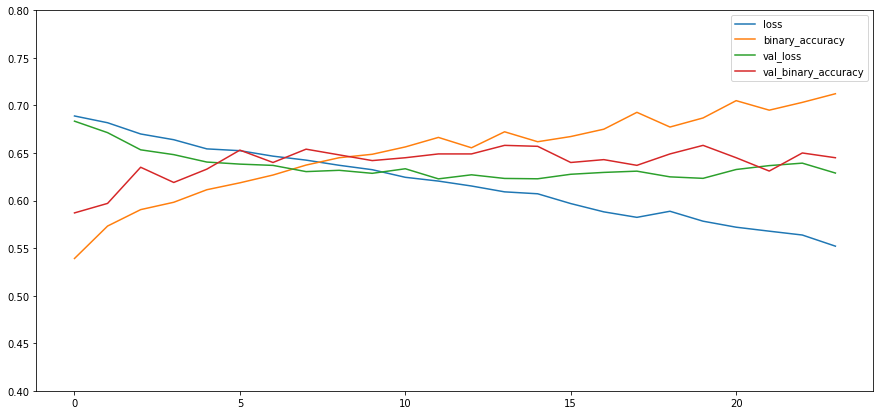

In [43]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 7))

plt.plot(history.history["loss"][1:], label = 'loss')
plt.plot(history.history["binary_accuracy"][1:], label = 'binary_accuracy')
plt.plot(history.history["val_loss"][1:], label = 'val_loss')
plt.plot(history.history["val_binary_accuracy"][1:], label = 'val_binary_accuracy')

plt.ylim(0.4, 0.8)

plt.legend()

In [45]:
final_model = create_final_model((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 6), kernel=3)
final_model.load_weights("final_model.hdf5")
final_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])

final_model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 0s 3ms/step - loss: 0.6232 - binary_accuracy: 0.6580


[0.6232331991195679, 0.6579999923706055]

## Train Augmented on augmented data

In [ ]:
final_model = create_final_model((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 6), kernel=3)
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
final_model.summary()

In [ ]:
mcp_save = keras.callbacks.ModelCheckpoint('final_model_augm.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='max')

history1 = final_model.fit(X_augm, y_augm, 
           batch_size=8, 
           epochs=25, 
           verbose=1,
           callbacks=[mcp_save],
           validation_data=(X_test, y_test))

history2 = final_model.fit(X_train, y_train, 
           batch_size=8, 
           epochs=25, 
           verbose=1,
           callbacks=[mcp_save],
           validation_data=(X_test, y_test))

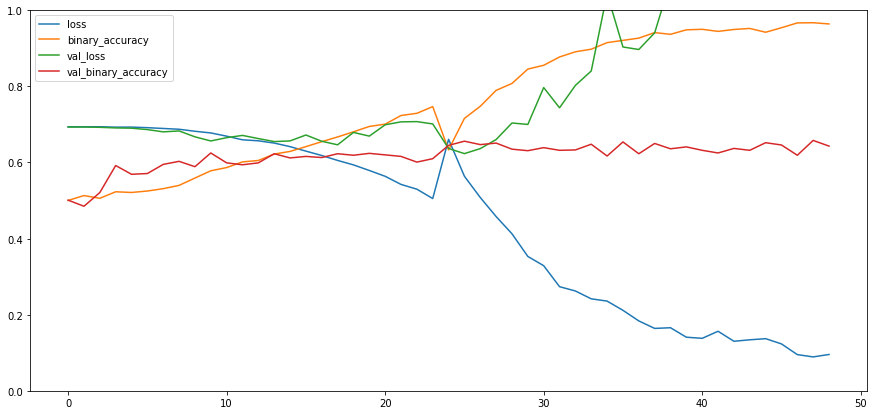

In [51]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 7))

plt.plot(history1.history["loss"][1:] + history2.history["loss"], label = 'loss')
plt.plot(history1.history["binary_accuracy"][1:] + history2.history["binary_accuracy"], label = 'binary_accuracy')
plt.plot(history1.history["val_loss"][1:] + history2.history["val_loss"], label = 'val_loss')
plt.plot(history1.history["val_binary_accuracy"][1:] + history2.history["val_binary_accuracy"], label = 'val_binary_accuracy')

plt.ylim(0, 1.0)

plt.legend()

In [52]:
final_model = create_final_model((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 6), kernel=3)
final_model.load_weights("final_model_augm.hdf5")
final_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])

final_model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 0s 3ms/step - loss: 1.1425 - binary_accuracy: 0.6580


[1.1424956321716309, 0.6579999923706055]